# **Titanic - Machine Learning from Disaster**

## Contents:
1. **X, y Dataframes Creation**
    * Import libraries
2. **X, y Summary**
3. **Data Cleaning**
    * Remove the columns with more than half missing values
4. **Exploratory Data Analysis*
5. **Data Visualization (Original Features)**
    * Correlation between features and target on heatmap
    * Sex vs Survived
    * Age vs Survived
    * Fare vs Survived
6. **Feature Engineering**
    * Create New Categorical Features
        1. Name Prefix
        2. Age Category
        3. Fare Category
        4. Family Size
    * Data Visualization of Created Categories
    * Imputing Age (using group means)
7. **Feature Selection**
8. **Model Creation**
    * Preprocessing Pipelines
    * Model Pipeline
    * Visualize the pipeline
9. **Training and Testing Model**
    * Grid Search & Cross Validation
    * Feature Importance
    * Confusion Matrix
    * Classification Report
10. **Predicting y**

# 1) X, y Dataframes Creation

## Import Data Analytics libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import ceil

## Import Machine Learning Libraries

In [54]:
from sklearn.pipeline import Pipeline

# To perform operations on columns:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ML algorithms:
from xgboost import XGBClassifier

# To evaluate performance model:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [55]:
# Read the data
X_y = pd.read_csv('./data/project2/train.csv', index_col='PassengerId')
X_test = pd.read_csv('./data/project2/test.csv', index_col='PassengerId')

# Remove rows with missing target
X_y = X_y.dropna(subset=['Survived'], axis=0)

#  Separate target y from predictors X
X = X_y.copy()
y = X.pop('Survived')

# 2) X, y Summary

In [56]:
X.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [57]:
# Creating function so that we can reuse it afterwords
def show_info(X,X_test):
    DataTypes = pd.DataFrame(X.dtypes.value_counts(),columns=['X'])
    DataTypes['X_test'] = X.dtypes.value_counts().values
    print("Number of Columns with different Data Types:\n")
    print(DataTypes,'\n')
    
    info = pd.DataFrame(X.dtypes, columns=['Dtype'])
    info['Unique_X'] = X.nunique().values
    info['Unique_X_test'] = X_test.nunique().values
    info['Null_X'] = X.isnull().sum().values
    info['Null_X_test'] = X_test.isnull().sum().values
    return info

In [58]:
show_info(X,X_test)

Number of Columns with different Data Types:

     X  X_test
0  NaN       5
1  NaN       3
2  NaN       2 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Pclass,int64,3,3,0,0
Name,object,891,418,0,0
Sex,object,2,2,0,0
Age,float64,88,79,177,86
SibSp,int64,7,7,0,0
Parch,int64,7,8,0,0
Ticket,object,681,363,0,0
Fare,float64,248,169,0,1
Cabin,object,147,76,687,327
Embarked,object,3,3,2,0


In [59]:
y.head(2)

PassengerId
1    0
2    1
Name: Survived, dtype: int64

In [60]:
y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

# 3) Data Cleaning

## Remove the columns with more than half missing values

In [61]:
# Making function so that we can reuse it in later stages as well
def show_null_values(X, X_test):
    
    # Making DataFrame for combining training and testing missing values
    null_values = pd.DataFrame(X.isnull().sum(), columns=['Train Data'])
    null_values['Test Data'] = X_test.isnull().sum().values

    # Showing only columns having missing values and sorting them
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    null_values = null_values.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    print("Total missing values:\n",null_values.sum(),'\n',sep='')
    
    return null_values

In [62]:
show_null_values(X, X_test)

Total missing values:
Train Data    866
Test Data     414
dtype: int64



,Train Data,Test Data
Cabin,687,327
Age,177,86
Embarked,2,0
Fare,0,1


In [63]:
# Show columns with more than half values missing
null_columns = [col for col in X.columns if X[col].isnull().sum() > X.shape[0]/2]
null_columns

['Cabin']

In [64]:
# Drop the above mentioned columns
X = X.drop(null_columns, axis=1)
X_test = X_test.drop(null_columns, axis=1)

# 4) Exploratory Data Analysis

### Correlation with target

In [65]:
Xy = X.join(y)


### Combination of Sex, Pclass and Embarked

In [66]:
df1 = Xy.groupby(['Sex','Pclass']).Survived.agg(['sum','count'])
df1['survival rate'] = round(df1['sum']/df1['count'],2)
df1

sum  count  survival rate
Sex    Pclass                           
female 1        91     94           0.97
       2        70     76           0.92
       3        72    144           0.50
male   1        45    122           0.37
       2        17    108           0.16
       3        47    347           0.14

**Insights:**
* Most of the females in 1st and 2nd class survived.
* Most of the males in 2nd and 3rd class didn't survive.

In [67]:
df2 = Xy.groupby(['Embarked','Pclass']).Survived.agg(['sum','count'])
df2['survival rate'] = round(df2['sum']/df2['count'],2)
df2

sum  count  survival rate
Embarked Pclass                           
C        1        59     85           0.69
         2         9     17           0.53
         3        25     66           0.38
Q        1         1      2           0.50
         2         2      3           0.67
         3        27     72           0.38
S        1        74    127           0.58
         2        76    164           0.46
         3        67    353           0.19

**Insights:**
* Highest survival rate - 1st Pclass passenger Embarked at C
* Lowest survival rate - 3rd Pclass passenger Embarked at S

In [68]:
df3 = Xy.groupby(['Embarked','Sex']).Survived.agg(['sum','count'])
df3['survival rate'] = round(df3['sum']/df3['count'],2)
df3

sum  count  survival rate
Embarked Sex                              
C        female   64     73           0.88
         male     29     95           0.31
Q        female   27     36           0.75
         male      3     41           0.07
S        female  140    203           0.69
         male     77    441           0.17

**Insights:**
* Highest survival rate - female passenger Embarked at C
* Lowest survival rate - male passenger Embarked at Q

# 5) Data Visualization

## Correlation between features and target on heatmap

### Insights from above correlation heatmap:
1. Survival is more linearly related to Pclass and Fare.
2. Pclass and Fare are negatively linear correlated. (as 1st class has more fare and 3rd class has less fare)
3. Parch and SibSp have more correlation. (So people which have Parents and Children with them are more likely to have with their Siblings and Spouse.)

## Sex vs Survived

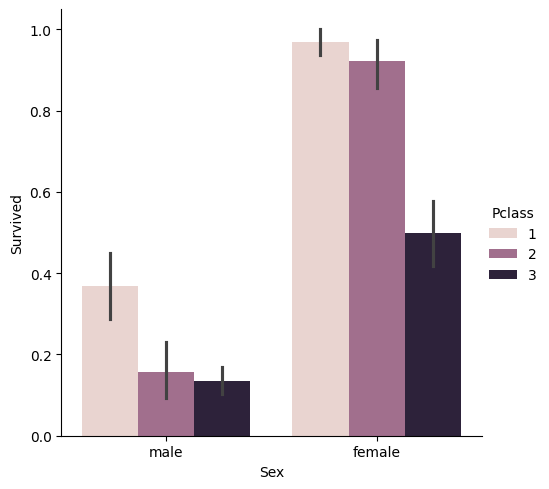

In [69]:
sns.catplot(data=Xy, x="Sex", y="Survived", hue="Pclass", kind="bar");

### Insights:
* Survival rate of female passengers was higher than that of male passengers.
* Survival rate was higher for upper class passengers than that of lower class passengers.

## Age vs Survived

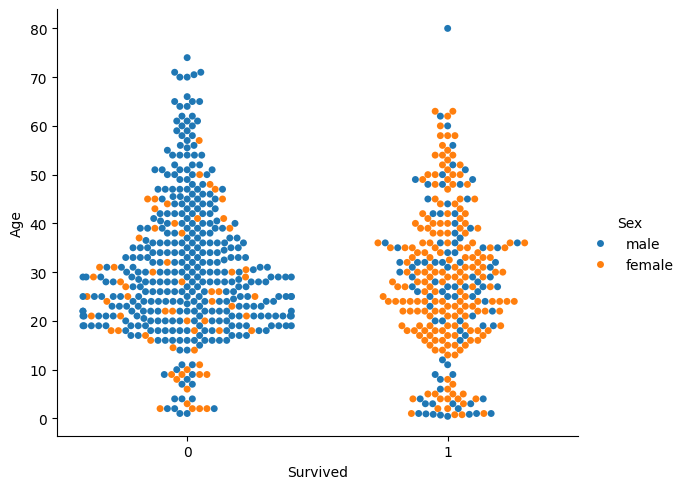

In [70]:
sns.catplot(data=Xy, y="Age", x="Survived", hue="Sex", kind="swarm", height=5, aspect=1.2);

### Insights:
* Male passengers with age more than 50 had less chances of survival.
* Passengers with age less than 10 had more chances of survival.

## Fare vs Survived

(0.0, 300.0)

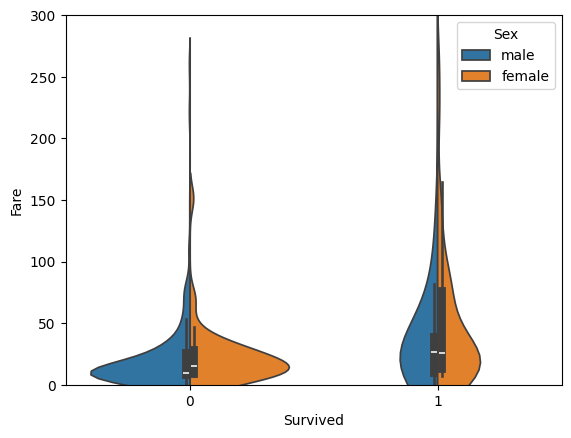

In [71]:
sns.violinplot(data=Xy, y="Fare", x="Survived", hue="Sex", split=True)
plt.ylim(0, 300)

### Insights:
* Passengers having more fare than 80 had more rate of survival.

# 6) Feature Engineering

## Create New Categorical Features

### 1] Name Prefix

In [72]:
X['Prefix'] = X['Name'].str.split(expand=True)[1]
X_test['Prefix'] = X_test['Name'].str.split(expand=True)[1]

In [73]:
prefixes = X.Prefix.value_counts()
top_prefixes = prefixes[prefixes>len(X)/25].index
top_prefixes

Index(['Mr.', 'Miss.', 'Mrs.', 'Master.'], dtype='object', name='Prefix')

In [74]:
X.Prefix = X.Prefix.apply(lambda x: x if x in top_prefixes else 'other')
X_test.Prefix = X_test.Prefix.apply(lambda x: x if x in top_prefixes else 'other')

In [75]:
df = pd.DataFrame(X['Prefix'].value_counts())
df['Prefix_test'] = X_test['Prefix'].value_counts().values
df

,count,Prefix_test
Prefix,,
Mr.,502,234
Miss.,179,77
Mrs.,121,70
other,49,19
Master.,40,18


## Imputing Age (using group means)

In [76]:
# Number of missing values in Age column
null_index=X.Age.isnull()
null_index_test=X_test.Age.isnull()
print(null_index.sum(),null_index_test.sum())

177 86


In [77]:
avg_ages = X.groupby(['Prefix','Pclass']).Age.mean().round()
pd.DataFrame(avg_ages)

Age
Prefix  Pclass      
Master. 1        5.0
        2        2.0
        3        5.0
Miss.   1       30.0
        2       22.0
        3       16.0
Mr.     1       42.0
        2       33.0
        3       29.0
Mrs.    1       42.0
        2       34.0
        3       34.0
other   1       42.0
        2       38.0
        3       29.0

In [78]:
for (i,k) in avg_ages.index:
    value = avg_ages.loc[i,k]
    X.loc[(X.Prefix==i) & (X.Pclass==k) & (X.Age.isnull()),'Age'] = value
    X_test.loc[(X_test.Prefix==i) & (X_test.Pclass==k) & (X_test.Age.isnull()),'Age'] = value

In [79]:
# Number of missing age values after imputation
print(X["Age"].isnull().sum(),X_test["Age"].isnull().sum())

0 0


In [80]:
# Rows where we imputed Age values
X[null_index].head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Prefix
PassengerId,,,,,,,,,,
6,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q,Mr.
18,2,"Williams, Mr. Charles Eugene",male,33.0,0,0,244373,13.0000,S,Mr.


In [81]:
# Now, we will combine known prefixes as these categories are redundent when Sex column is present.
X.Prefix = X.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')
X_test.Prefix = X_test.Prefix.replace(['Mr.', 'Miss.', 'Mrs.', 'Master.'], 'known')

In [82]:
# We do not need 'Name' column anymore.
X = X.drop(['Name'], axis=1)
X_test = X_test.drop(['Name'], axis=1)

### 2] Age Category

In [83]:
def Age_categorise(df):
    df['Age_Cat'] = pd.cut(df.Age, bins = [0,10,40,60,100], labels = ['child','young','adult','senior'])
    
Age_categorise(X)
Age_categorise(X_test)
X['Age_Cat'].dtype

CategoricalDtype(categories=['child', 'young', 'adult', 'senior'], ordered=True, categories_dtype=object)

In [84]:
df = pd.DataFrame(X['Age_Cat'].value_counts())
df['Age_Cat_test'] = X_test['Age_Cat'].value_counts().values
df

,count,Age_Cat_test
Age_Cat,,
young,644,307
adult,157,75
child,68,25
senior,22,11


### 3] Fare Category

In [85]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [86]:
def Fare_categorise(df):
    df['Fare_Cat'] = pd.qcut(df.Fare, q=4, labels = ['low','medium','high','very_high'])
    
Fare_categorise(X)
Fare_categorise(X_test)
X['Fare_Cat'].dtype

CategoricalDtype(categories=['low', 'medium', 'high', 'very_high'], ordered=True, categories_dtype=object)

In [87]:
df = pd.DataFrame(X['Fare_Cat'].value_counts())
df['Fare_Cat_test'] = X_test['Fare_Cat'].value_counts().values
df

,count,Fare_Cat_test
Fare_Cat,,
medium,224,114
low,223,105
high,222,102
very_high,222,96


### 4] Family Size

In [88]:
X['Family'] = X['SibSp'] + X['Parch']
X_test['Family'] = X_test['SibSp'] + X_test['Parch']

X = X.drop(['SibSp','Parch'],axis=1)
X_test = X_test.drop(['SibSp','Parch'],axis=1)

In [89]:
X.Family.value_counts()

Family
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

In [90]:
def Categorize_Family(df):
    df['Family_Size'] = pd.cut(df.Family, bins = [-1,0,2,12], labels = ['alone', 'medium', 'large'])
    
Categorize_Family(X)
Categorize_Family(X_test)

In [91]:
df = pd.DataFrame(X['Family_Size'].value_counts())
df['Family_Size_test'] = X_test['Family_Size'].value_counts().values
df

,count,Family_Size_test
Family_Size,,
alone,537,253
medium,263,131
large,91,34


Let us see newly created categorical columns.

In [92]:
X.head(2)

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
1,3,male,22.0,A/5 21171,7.2500,S,known,young,low,1,medium
2,1,female,38.0,PC 17599,71.2833,C,known,young,very_high,1,medium


In [93]:
X_test.head(2)

,Pclass,Sex,Age,Ticket,Fare,Embarked,Prefix,Age_Cat,Fare_Cat,Family,Family_Size
PassengerId,,,,,,,,,,,
892,3,male,34.5,330911,7.8292,Q,known,young,low,0,alone
893,3,female,47.0,363272,7.0000,S,known,adult,low,1,medium


## Data Visualization of Created Categories

In [94]:
# Concatenating X and y for Data Visualization purpose
Xy = X.copy()
Xy['Survived'] = y.copy()

In [95]:
# Making matplotlib parameters default
plt.rcParams.update(plt.rcParamsDefault)

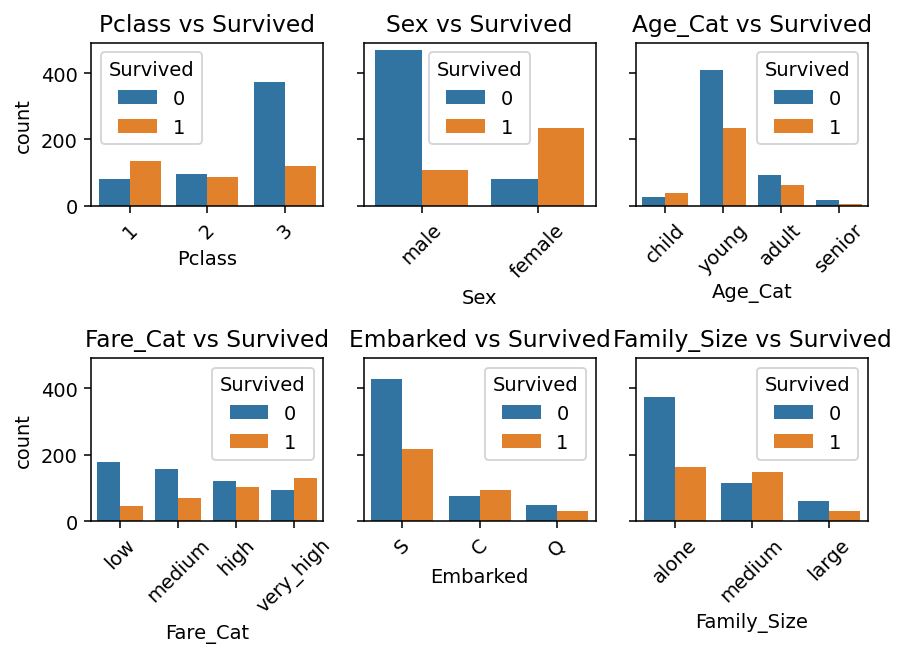

In [96]:
l=['Pclass','Sex','Age_Cat','Fare_Cat','Embarked','Family_Size']
figure, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=False, dpi=140)
index = 0
axes = axes.flatten()
for axis in axes:
    sns.countplot(x = l[index], hue = "Survived", data = Xy, ax=axis)
    axis.set_title(l[index]+' vs Survived')
    index = index+1
    plt.tight_layout()
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)
plt.show()

### Insights: 
In each of the plots for feature vs target, we can see one category has more chance of survival than other categories as count of survived=1 is more than survived=0:
* Pclass - 1
* Sex - female
* Age_Cat - 0
* Fare_Cat - 3
* Embarked - C
* Family_Size - 1

# 7) Feature Selection

In [97]:
# Columns to choose from for model training and prediction
X.columns

Index(['Pclass', 'Sex', 'Age', 'Ticket', 'Fare', 'Embarked', 'Prefix',
       'Age_Cat', 'Fare_Cat', 'Family', 'Family_Size'],
      dtype='object')

In [98]:
# We used Categorical columns Age_Cat, Fare_Cat, Family_Size for visualizations only.
# Select columns for classification model
X = X[['Age', 'Pclass', 'Sex', 'Family_Size']]
X_test = X_test[[ 'Age', 'Pclass', 'Sex', 'Family_Size']]

In [99]:
# Select numerical columns
numerical_cols = [cname for cname in X.columns 
                  if X[cname].dtype in ['int64', 'float64']]

In [100]:
# Select categorical columns with low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X.columns 
                    if X[cname].nunique() < 10 and
                    X[cname].dtype in ["object","category"]]

In [101]:
# Keep selected columns only
my_cols = numerical_cols + categorical_cols
X = X[my_cols]
X_test = X_test[my_cols]

## Final X and X_test on which regression model will be trained

In [102]:
print(len(categorical_cols),len(numerical_cols))

2 2


In [103]:
X_test.head(2)

,Age,Pclass,Sex,Family_Size
PassengerId,,,,
892,34.5,3,male,alone
893,47.0,3,female,medium


In [104]:
show_info(X,X_test)

Number of Columns with different Data Types:

     X  X_test
0  NaN       1
1  NaN       1
2  NaN       1
3  NaN       1 



,Dtype,Unique_X,Unique_X_test,Null_X,Null_X_test
Age,float64,88,79,0,0
Pclass,int64,3,3,0,0
Sex,object,2,2,0,0
Family_Size,category,3,3,0,0


# 8) Model Creation

## Preprocessing Pipelines

In [105]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

In [106]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [107]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Model Pipeline

In [108]:
# Create object of XGBClassifier class
xgb = XGBClassifier()

# Bundle preprocessing and modeling code in a pipeline
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

## Visualize the pipeline

In [109]:
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Family_Size'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsampl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# 9) Training and Testing Model

## Grid Search & Cross Validation

In [110]:
param_grid = [
    {
        "model__reg_lambda": [50],
        "model__subsample": [0.7,1],
        "model__learning_rate": [0.4],
        "model__n_estimators": [5, 10, 20],
        "model__max_depth": [3, 4, 5]
    }
]
grid_search = GridSearchCV(classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X, y);

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [111]:
print("Best params:",grid_search.best_params_,sep='\t',end='\n\n')
print("Best score in grid search:",round(grid_search.best_score_,3),sep='\t')
print("Score on whole trained data:",round(grid_search.score(X, y),3),sep='\t')

Best params:	{'model__learning_rate': 0.4, 'model__max_depth': 5, 'model__n_estimators': 20, 'model__reg_lambda': 50, 'model__subsample': 0.7}

Best score in grid search:	0.819
Score on whole trained data:	0.835


In [112]:
# Top 5 parameter combinations
df = pd.DataFrame(grid_search.cv_results_)
display(df.sort_values('rank_test_score')[:5])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__reg_lambda,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
16,0.023340,0.000908,0.005651,0.002286,0.4,5,20,50,0.7,"{'model__learning_rate': 0.4, 'model__max_dept...",0.808081,0.831650,0.818182,0.819304,0.009655,1
3,0.016376,0.000474,0.008002,0.000007,0.4,3,10,50,1.0,"{'model__learning_rate': 0.4, 'model__max_dept...",0.811448,0.828283,0.811448,0.817059,0.007936,2
5,0.020178,0.000226,0.005337,0.001887,0.4,3,20,50,1.0,"{'model__learning_rate': 0.4, 'model__max_dept...",0.797980,0.828283,0.821549,0.815937,0.012992,3
11,0.021501,0.001776,0.005342,0.001897,0.4,4,20,50,1.0,"{'model__learning_rate': 0.4, 'model__max_dept...",0.791246,0.828283,0.821549,0.813692,0.016109,4
9,0.017419,0.001813,0.006510,0.001788,0.4,4,10,50,1.0,"{'model__learning_rate': 0.4, 'model__max_dept...",0.794613,0.821549,0.821549,0.812570,0.012698,5


## Feature Importance

In [113]:
Feature_Imp = grid_search.best_estimator_.named_steps["model"].feature_importances_
Feature_Imp

array([0.04192288, 0.12967072, 0.7129874 , 0.        , 0.0171306 ,
       0.05575479, 0.04253366], dtype=float32)

In [114]:
# Predicting y for trained data
y_pred = grid_search.predict(X)

# Converting y_pred from Array to DataFrame with appropriate index and column name
y_pred = pd.DataFrame(y_pred, index=X.index, columns=['Survived_Predicted'])

In [115]:
# Checking trainig data without preprocessing (features, actual target and predicted target)
Xyy = pd.concat([X,y,y_pred],axis=1)
Xyy.head(2)

,Age,Pclass,Sex,Family_Size,Survived,Survived_Predicted
PassengerId,,,,,,
1,22.0,3,male,medium,0,0
2,38.0,1,female,medium,1,1


In [116]:
# Preprocessed (Imputed and OneHotCoded) Training and Test data using Pipeline
column_values = ['Age','Pclass','Sex_female','Sex_male','Family_alone','Family_large','Family_medium']
X_processed = pd.DataFrame(grid_search.best_estimator_.named_steps["preprocessor"].transform(X), columns=column_values)
X_processed.head(2)

,Age,Pclass,Sex_female,Sex_male,Family_alone,Family_large,Family_medium
0,22.0,3.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,1.0,0.0,0.0,0.0,1.0


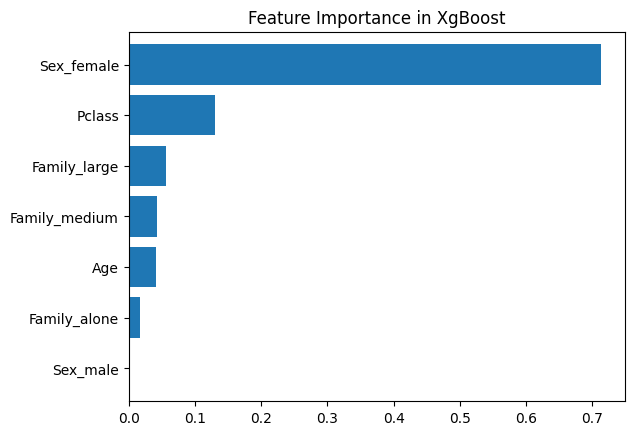

In [117]:
ax =pd.Series(Feature_Imp,X_processed.columns).sort_values(ascending=True).plot.barh(width=0.8)
ax.set_title('Feature Importance in XgBoost')
plt.show()

**Note:**
* From above plot, we can see that *One Hot Encoded* column 'Sex_male' has zero importance in trained XGBoost model. This is because that same information is conveyed in 'Sex_feamle'. (If the passenger is not female, then the passenger is male.)

## Confusion Matrix (for training data)

In [118]:
# Credit: 'https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea'
cm = confusion_matrix(y, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'])
ax.set(ylabel="Actual y", xlabel="Predicted y");

## Classification Report (for training data)

In [119]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       549
           1       0.82      0.73      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.84      0.83       891



In [122]:
# Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y,y_pred)))
print('Precision Score : ' + str(precision_score(y,y_pred).round(3)))
print('Recall Score : ' + str(recall_score(y,y_pred).round(3)))
print('F1 Score : ' + str(f1_score(y,y_pred).round(3)))

Accuracy Score : 0.835016835016835
Precision Score : 0.82
Recall Score : 0.731
F1 Score : 0.773


# 10) Predicting y

In [123]:
# Generate test predictions
y_test_pred = grid_search.predict(X_test)

# Converting y_pred from Array to DataFrame with appropriate index and column name
y_test_pred = pd.DataFrame(y_test_pred, index=X_test.index, columns=['Survived_Predicted'])

In [124]:
# Checking testing data with features and predicted target
Xy_test = pd.concat([X_test,y_test_pred],axis=1)
Xy_test.head(2)

,Age,Pclass,Sex,Family_Size,Survived_Predicted
PassengerId,,,,,
892,34.5,3,male,alone,0
893,47.0,3,female,medium,0


In [125]:
# Save output to CSV file
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': y_test_pred.Survived_Predicted})
output.to_csv('submission.csv', index=False)

In [126]:
# Submit results
submission_data = pd.read_csv("submission.csv")
submission_data.head(2)

,PassengerId,Survived
0,892,0
1,893,0
